In [1]:
import time
import argparse
import numpy as np
import scipy.io as sio
from copy import deepcopy
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch import optim
from einops import rearrange
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from caps_vit import Margin_Recon_Loss

from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test_number
from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label


from Utils import ActivationOutputData, safe_norm
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from Utils import list_to_colormap, classification_map, print_args


from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch
from active_learning import initialize_models, search_informative_samples


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Indian', 'Pavia', 'KSC'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='CAF', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=9, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
parser.add_argument('--iterations', type=int, default=5, help='active learning iterations')
args = parser.parse_args(args=[])

In [3]:
# 设置torch.random和torch.cuda.random随机种子，使模型的各种参数初始化以及DataLoader在生成随机小批量时在每次实验过程中
# 均保持一致，以保证每次运行的实验结果尽量保持相同

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [4]:
# prepare data
if args.dataset == 'Indian':
    data = sio.loadmat('./dataset/Indian_pines_corrected.mat')['indian_pines_corrected']
    label = sio.loadmat('./dataset/Indian_pines_gt.mat')['indian_pines_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_number(label, args.train_number, seed=args.seed)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 9
mirror_data shape : [520, 622, 176]
**************************************************
x_train shape = (13, 9, 9, 176), type = float64
x_test  shape = (5198, 9, 9, 176), type = float64
x_true  shape = (5211, 9, 9, 176), type = float64
**************************************************
y_train: shape = (13,), type = int64
y_test: shape = (5198,), type = int64
y_true: shape = (5211,), type = int64
**************************************************


In [8]:
# load data
x_train_ask = torch.from_numpy(x_train).unsqueeze(1).type(torch.FloatTensor)  # (13, 1, 7, 7, 176)
x_train_cap = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (13, 176, 7, 7)
print(x_train_ask.shape, x_train_cap.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label_Ask = Data.TensorDataset(x_train_ask, y_train)
Train_Label_Cap = Data.TensorDataset(x_train_cap, y_train)
train_loader_ask = Data.DataLoader(Train_Label_Ask, batch_size=args.batch_size, shuffle=True)
train_loader_cap = Data.DataLoader(Train_Label_Cap, batch_size=args.batch_size, shuffle=True)


x_test_ask = torch.from_numpy(x_test).unsqueeze(1).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
x_test_cap = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 176, 7, 7)
print(x_test_ask.shape, x_test_cap.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label_Ask = Data.TensorDataset(x_test_ask, y_test)
Test_Label_Cap = Data.TensorDataset(x_test_cap, y_test)
test_loader_ask = Data.DataLoader(Test_Label_Ask, batch_size=args.batch_size, shuffle=True)
test_loader_cap = Data.DataLoader(Test_Label_Cap, batch_size=args.batch_size, shuffle=True)


x_true_ask = torch.from_numpy(x_true).unsqueeze(1).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
x_true_cap = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 176, 7, 7)
print(x_true_ask.shape, x_true_cap.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label_Ask = Data.TensorDataset(x_true_ask, y_true)
True_Label_Cap = Data.TensorDataset(x_true_cap, y_true)
true_loader_ask = Data.DataLoader(True_Label_Ask, batch_size=100, shuffle=False)
true_loader_cap = Data.DataLoader(True_Label_Cap, batch_size=100, shuffle=False)

candidate_loader = deepcopy(test_loader_cap)

torch.Size([13, 1, 9, 9, 176]) torch.Size([13, 176, 9, 9])
torch.Size([5198, 1, 9, 9, 176]) torch.Size([5198, 176, 9, 9])
torch.Size([5211, 1, 9, 9, 176]) torch.Size([5211, 176, 9, 9])


## Active Learning

In [9]:
for i in range(args.iterations):
    model_cap, model_ask, model_glom = initialize_models(band, args.patch_size, num_classes)
    # criterion
    criterion_cap = Margin_Recon_Loss()
    criterion_ask = nn.CrossEntropyLoss()
    criterion_glom = nn.CrossEntropyLoss()

    # optimizer
    optim_backbone = optim.Adam(model_cap['backbone'].parameters(), lr=args.learning_rate, 
                                weight_decay=args.weight_decay)
    optim_module   = optim.SGD(model_cap['module'].parameters(), lr=1e-3, momentum=0.9, 
                               weight_decay=args.weight_decay)
    optimizer_cap = {'backbone': optim_backbone, 'module': optim_module}
    optimizer_ask = optim.Adam(model_ask.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, 
                               weight_decay=0)
    optimizer_glom = optim.Adam(model_glom.parameters(), lr=1e-3)

    # learning scheduler
    sched_backbone = optim.lr_scheduler.ExponentialLR(optim_backbone, gamma=args.gamma)
    sched_module   = optim.lr_scheduler.MultiStepLR(optim_module, milestones=[50, 100])
    scheduler_cap = {'backbone': sched_backbone, 'module': sched_module}
    scheduler_ask = optim.lr_scheduler.ExponentialLR(optimizer_ask, gamma=args.gamma)
    scheduler_glom = optim.lr_scheduler.ExponentialLR(optimizer_glom, gamma=args.gamma)

    print("****************************************************************")
    print('Training S3KAIResNet')
    # train model
    model_ask.train()
    tic = time.time()
    for epoch in range(args.epoches):
        # 计算的是移动平均准确率
        train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(model_ask, train_loader_ask, 
                                                                           criterion_ask, optimizer_ask)
        #train_acc, train_obj, tar_train, pre_train = train_epoch(model, gen_train_loader, criterion, optimizer)
        OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
        scheduler_ask.step()

    toc = time.time()
    torch.save(model_ask.state_dict(), './models/A2S2KResNet_{}.pt'.format(i+1))
    print("Running Time: {:.2f}".format(toc-tic))
    print("****************************************************************")
    
    print('Training CapsViT')
    # train model
    model_cap['backbone'].train()
    model_cap['module'].train()
    tic = time.time()
    for epoch in range(args.epoches):
        # 计算的是移动平均准确率
        train_acc, train_obj, tar_train, pre_train = train_epoch(model_cap, train_loader_cap, 
                                                                 criterion_cap, optimizer_cap)
        #train_acc, train_obj, tar_train, pre_train = train_epoch(model, gen_train_loader, criterion, optimizer)
        OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
        scheduler_cap['backbone'].step()
        scheduler_cap['module'].step()

    toc = time.time()
    torch.save(model_cap['backbone'].state_dict(), './models/CapsCAF_backbone_{}.pt'.format(i+1))
    torch.save(model_cap['module'].state_dict(), './models/CapsCAF_module_{}.pt'.format(i+1))
    print("Running Time: {:.2f}".format(toc-tic))
    print("****************************************************************")

    print('Training CapsGLOM')
    # train model
    model_glom.train()
    tic = time.time()
    for epoch in range(args.epoches):
        # 计算的是移动平均准确率
        train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(model_glom, train_loader_cap, 
                                                                           criterion_glom, optimizer_glom)
        #train_acc, train_obj, tar_train, pre_train = train_epoch(model, gen_train_loader, criterion, optimizer)
        OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
        scheduler_glom.step()

    toc = time.time()
    torch.save(model_glom.state_dict(), './models/CapsGLOM_{}.pt'.format(i+1))
    print("Running Time: {:.2f}".format(toc-tic))
    print("****************************************************************")

    if i < args.iterations - 1:
        informative_samples, informative_labels, candidate_loader = \
        search_informative_samples(model_cap, model_ask, model_glom, candidate_loader)

        x_train_ask = torch.cat([x_train_ask, rearrange(informative_samples, 'b c h w -> b h w c').unsqueeze(1)])
        x_train_cap = torch.cat([x_train_cap, informative_samples])
        print(x_train_ask.shape, x_train_cap.shape)
        y_train = torch.cat([y_train, informative_labels])

        Train_Label_Cap = Data.TensorDataset(x_train_cap, y_train)
        Train_Label_Ask = Data.TensorDataset(x_train_ask, y_train)
        train_loader_cap = Data.DataLoader(Train_Label_Cap, batch_size=args.batch_size, shuffle=True)
        train_loader_ask = Data.DataLoader(Train_Label_Ask, batch_size=args.batch_size, shuffle=True)

****************************************************************
Training S3KAIResNet
Epoch: 001 train_loss: 2.6597 train_acc: 7.6923
Epoch: 002 train_loss: 2.1728 train_acc: 38.4615
Epoch: 003 train_loss: 1.9150 train_acc: 61.5385
Epoch: 004 train_loss: 1.7248 train_acc: 69.2308
Epoch: 005 train_loss: 1.6017 train_acc: 76.9231
Epoch: 006 train_loss: 1.5104 train_acc: 76.9231
Epoch: 007 train_loss: 1.4278 train_acc: 92.3077
Epoch: 008 train_loss: 1.3561 train_acc: 92.3077
Epoch: 009 train_loss: 1.2889 train_acc: 92.3077
Epoch: 010 train_loss: 1.2288 train_acc: 92.3077
Epoch: 011 train_loss: 1.1778 train_acc: 100.0000
Epoch: 012 train_loss: 1.1306 train_acc: 100.0000
Epoch: 013 train_loss: 1.0896 train_acc: 100.0000
Epoch: 014 train_loss: 1.0530 train_acc: 100.0000
Epoch: 015 train_loss: 1.0171 train_acc: 100.0000
Epoch: 016 train_loss: 0.9858 train_acc: 100.0000
Epoch: 017 train_loss: 0.9558 train_acc: 100.0000
Epoch: 018 train_loss: 0.9276 train_acc: 100.0000
Epoch: 019 train_loss: 0.

****************************************************************
Testing CapsViT


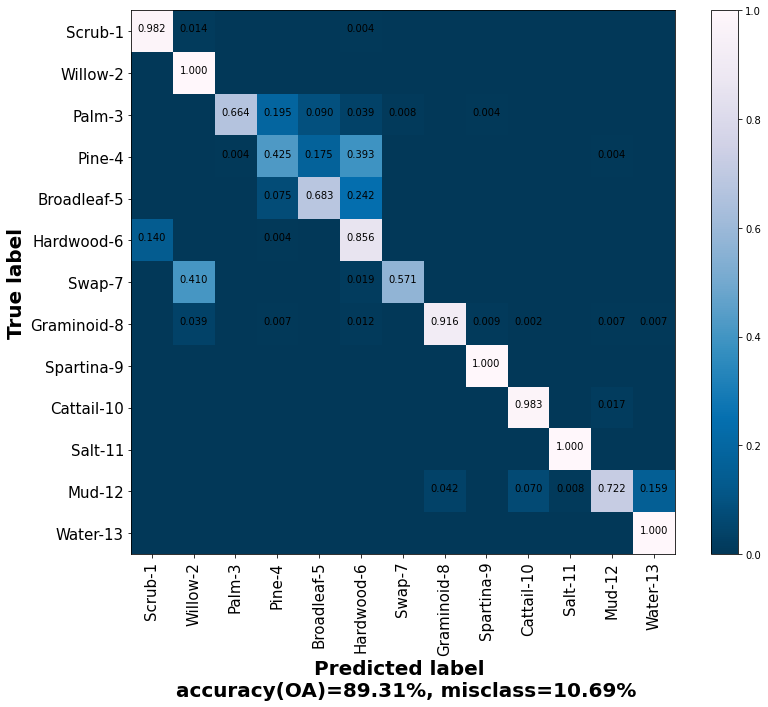

****************************************************************
CapsViT Final Result:
OA: 89.28% | AA: 83.00% | Kappa: 0.88
[0.98157895 1.         0.6627451  0.42231076 0.68125    0.85526316
 0.56730769 0.91627907 1.         0.98263027 1.         0.72111554
 1.        ]
****************************************************************
****************************************************************
Testing S3KAIResNet


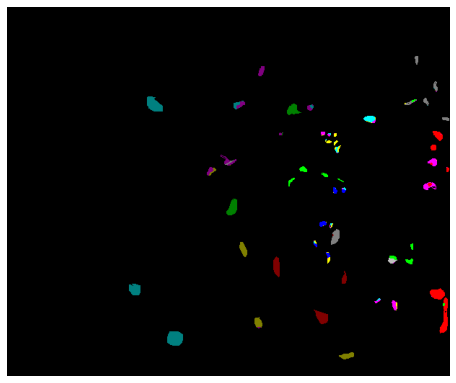

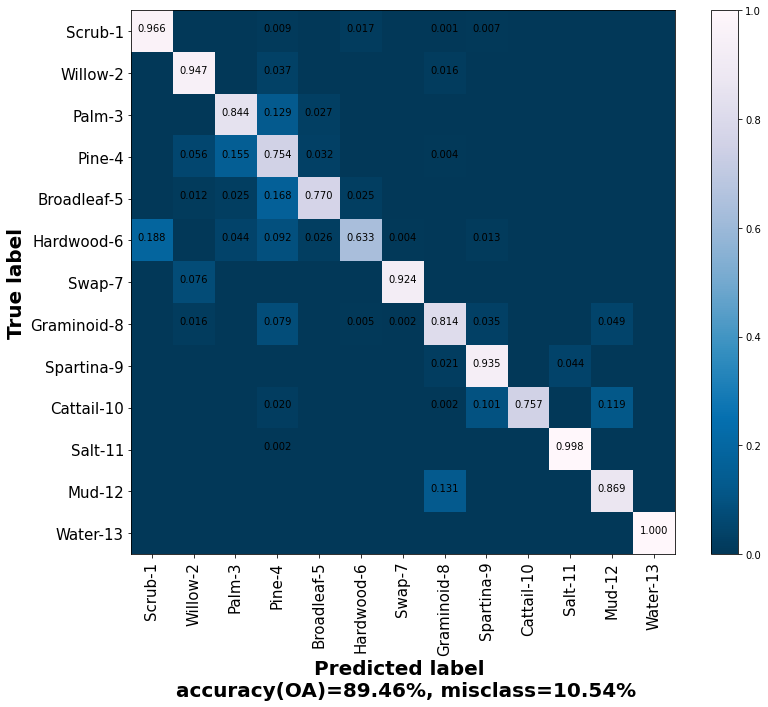

****************************************************************
S3KAIResNet Final Result:
OA: 89.44% | AA: 86.18% | Kappa: 0.88
[0.96578947 0.94628099 0.84313725 0.75298805 0.76875    0.63157895
 0.92307692 0.81395349 0.9344894  0.75682382 0.99760766 0.8685259
 1.        ]
****************************************************************
Testing CapsGLOM


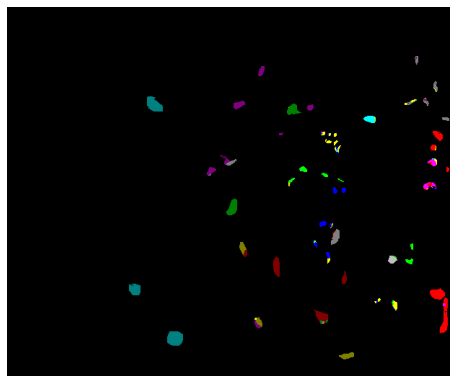

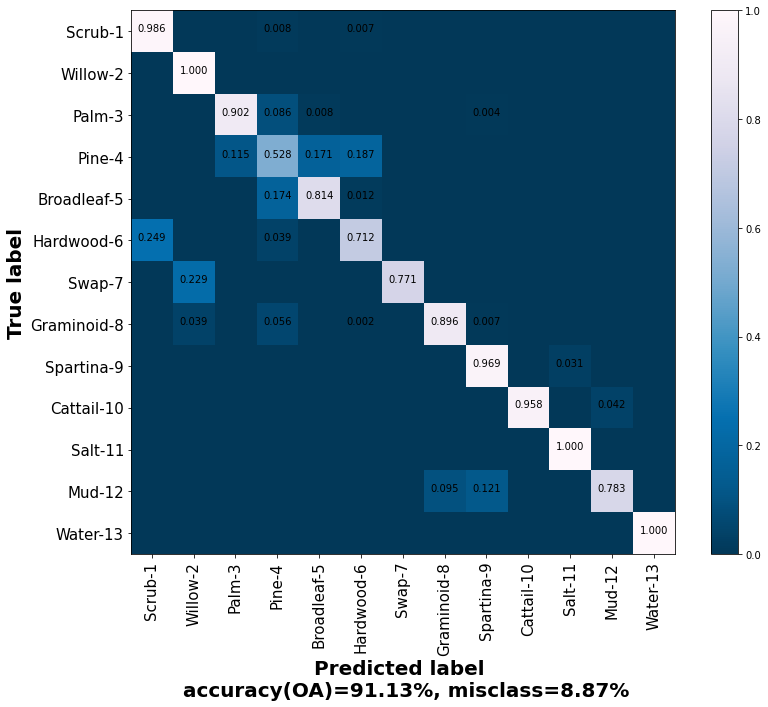

****************************************************************
CapsGLOM Final Result:
OA: 91.11% | AA: 87.01% | Kappa: 0.90
[0.98552632 1.         0.90196078 0.52589641 0.8125     0.71052632
 0.76923077 0.89534884 0.96917148 0.95781638 1.         0.78286853
 1.        ]
****************************************************************


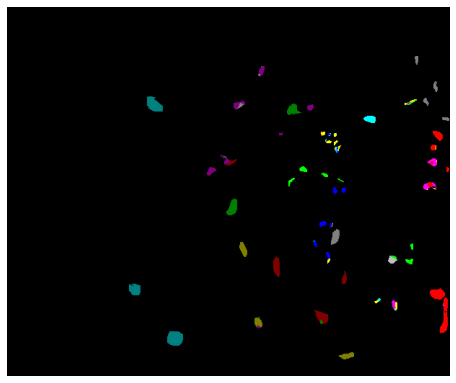

In [12]:
model_cap, model_ask, model_glom = initialize_models(band, args.patch_size, num_classes)

model_cap['backbone'].load_state_dict(torch.load('./models/CapsCAF_backbone_{}.pt'.format(args.iterations)))
model_cap['module'].load_state_dict(torch.load('./models/CapsViT_module_{}.pt'.format(args.iterations)))
model_ask.load_state_dict(torch.load('./models/A2S2KResNet_{}.pt'.format(args.iterations)))
model_glom.load_state_dict(torch.load('./models/CapsGLOM_{}.pt'.format(args.iterations)))


print("****************************************************************")
print('Testing S3KAIResNet')
model_ask.eval()
tar_test, pre_test = auxiliary_test_epoch(model_ask, test_loader_ask)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(model_ask, true_loader_ask)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(y_true, pre_u)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_A2S2KResNet.pdf')

predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))
classification_map(predict_map, './Predict_Map_A2S2KResNet.pdf')

print("****************************************************************")
print("S3KAIResNet Final Result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.2f}".format(OA_test * 100., AA_mean_test * 100., Kappa_test))
print(AA_test)
print("****************************************************************")


print('Testing CapsViT')
model_cap['backbone'].eval()
model_cap['module'].eval()
tar_test, pre_test = test_epoch(model_cap, test_loader_cap)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = valid_epoch(model_cap, true_loader_cap)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(y_true, pre_u)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_CapsCAF.pdf')

predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))
classification_map(predict_map, './Predict_Map_CapsViT.pdf')

print("****************************************************************")
print("CapsViT Final Result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.2f}".format(OA_test * 100., AA_mean_test * 100., Kappa_test))
print(AA_test)
print("****************************************************************")

print('Testing CapsGLOM')
model_glom.eval()
tar_test, pre_test = auxiliary_test_epoch(model_glom, test_loader_cap)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(model_glom, true_loader_cap)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(y_true, pre_u)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_MobileViT.pdf')

predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))
classification_map(predict_map, './Predict_Map_MobileViT.pdf')

print("****************************************************************")
print("CapsGLOM Final Result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.2f}".format(OA_test * 100., AA_mean_test * 100., Kappa_test))
print(AA_test)
print("****************************************************************")